In [4]:
import torch
import json
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import gensim #For word2vec
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import time
import nltk
import random
from numpy.random import choice as randomchoice
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import sys
# import transformers
# from transformers import AutoModel, BertTokenizerFast
# import torchtext
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import matplotlib as mlt
import gensim.downloader as api
import torchtext.vocab as vocab

In [5]:
glove_model = api.load("glove-wiki-gigaword-200")

In [9]:
# bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [20]:
train_start_time = time.time();
# val_file = sys.argv[2];
train_file = 'data/train.json'
val_file = 'data/dev.json'
test_file = 'data/test.json'

tokenize_func = nltk.tokenize.WordPunctTokenizer().tokenize
punctuations = '!"#$%&\'()*+,-./:;=?@[\\]^`{|}~'
def is_numeric(s):
    try:
        float(s)
        return True
    except ValueError: #Classic way to get is_numeric
        return False
def tokenize(sentence, with_num = True):
    old = tokenize_func(sentence.lower());
    s = [];
    for word in old:
        running = [];
        for character in word:
            if(character in punctuations):
                if(len(running) > 0):
                    s.append(''.join(running));
                    running = []; #emptying the running list.
                s.append(character); #then adding the punctuation.
            else:
                running.append(character);
        if(len(running) > 0):
            s.append(''.join(running));
        #this above code ensures that what we have is also split on punctuation
    if(with_num):
        return s; #If with_num is true, return the sentence as it is, without converting the numbers to <NUM>
    for i in range(len(s)):
        if(is_numeric(s[i])):
            s[i] = '<NUM>'; #replaces numbers with <NUM>
    return s;

def tokenize_with_num(sentence): #just tokenizes normally. No replacement of numbers
    s = tokenize_func(sentence.lower());
    return s;

def get_embedding_index(sentences, model):
    return ([tokenize_and_get_embedding_index(sentence, model) for sentence in sentences]);

def tokenize_and_get_embedding_index_as_list(sentence, vocab, with_num = False):
    s = tokenize(sentence, with_num = with_num);
    # FOr now testing with No UNK, Later will have to add UNK
    tens = ([vocab.get(word, vocab['<UNK>']) for word in s]) # if (word in vocab)]); #if the word is not in the punctuation, only then we add it.
    return tens;

def tokenize_and_get_embedding_index(sentence, vocab, with_num = False):
    s = tokenize(sentence, with_num = with_num);
    # FOr now testing with No UNK, Later will have to add UNK
    tens = torch.tensor([vocab.get(word, vocab['<UNK>']) for word in s]) # if (word in vocab)]); #if the word is not in the punctuation, only then we add it.
    return tens;
    if(len(tens) == 0):
        return torch.tensor([vocab.get(word, vocab['<UNK>']) for word in s]) #using UNK in this case.
    else:
        return tens;

In [21]:
tokenize("const_100")

['const_100']

In [22]:
with open(train_file) as f:
    train_data = json.load(f)
with open(val_file) as f:
    val_data = json.load(f)
with open(test_file) as f:
    test_data = json.load(f)

In [23]:
global_max_len = 120;

In [24]:
## Postprocessing the code to remove the last '|' that is sometimes randomly present.
def remove_last_extra(data):
    for i in range(len(data)):
        if(data[i]['linear_formula'][-1] == '|'):
            data[i]['linear_formula'] = data[i]['linear_formula'][:-1];
        
    return data; #although not really needed.
remove_last_extra(val_data);
remove_last_extra(train_data);
remove_last_extra(test_data);

In [25]:
class glove_vectors():
    def get_word_embedding(word, glove_vectors, dim):
        if word in glove_vectors.key_to_index: #if the key is present we initialize it as glove embedding
            return torch.tensor(glove_vectors[word])
        else:
            return torch.rand(dim)  # Initi
    def __init__(self, sentences, glove_model, dim=200):
        self.vocabulary = set(['<START>', '<END>', '<PAD>', '<UNK>', '<NUM>']);
        for sentence in sentences:
            for word in tokenize(sentence):
                self.vocabulary.add(word); #creates the vocabulary.
        self.word_to_index = {word: i for i, word in enumerate(self.vocabulary)};
        self.index_to_word = {i: word for i, word in enumerate(self.vocabulary)};
        self.wordvec = [0] * len(self.vocabulary); #initializing the encoder_wordvec list
        rand_count = 0;
        for i in range(len(self.vocabulary)):
            self.wordvec[i] = glove_vectors.get_word_embedding(self.index_to_word[i], glove_model, dim);
        self.wordvec = torch.stack(self.wordvec); #stacking the list of tensors to form a tensor.

In [26]:
encoder_vectors = glove_vectors([data['Problem'] for data in train_data], glove_model);
decoder_vectors = glove_vectors([data['linear_formula'] for data in train_data], glove_model);

In [27]:
with open('mysaved.pkl', 'wb') as f:
    pickle.dump([encoder_vectors, decoder_vectors], f);

In [28]:
class LSTM_on_words(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, wordvectors, padding_index,bidirectional=True, dropout=0.0):
        super(LSTM_on_words, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(wordvectors), padding_idx=padding_index,freeze=True).to(device);
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional).to(device);

    def forward(self, x, x_lengths):
        # Embedding
        out = self.embedding(x)
        # Pack padded sequence
        # lengths = x_lengths.detach().cpu().numpy();
        out = pack_padded_sequence(out, x_lengths, batch_first=True, enforce_sorted=False).to(device);
        out, (hidden, cell) = self.lstm(out)
        # Unpack packed sequence
        out, _ = pad_packed_sequence(out, batch_first=True)
        return out, (hidden, cell);

class FeedForward(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(FeedForward, self).__init__()
        self.layers = [];
        self.ReLU = nn.ReLU(inplace=False)
        for i in range(len(layer_sizes)):
            if(i == 0):
                self.layers.append(nn.Linear(input_size, layer_sizes[i]));
            else:
                self.layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]));
            if(i != len(layer_sizes) - 1): #add Relu only if its not the last layer, since that is the output layer that we will softmax over.
                self.layers.append(self.ReLU);
        self.all_layers = nn.Sequential(*self.layers)
    def forward(self, x):
        out = self.all_layers(x)
        return out

In [29]:
class mathDataset(Dataset):
    def __init__(self, data, global_max_len = global_max_len):
        self.data = data;
        # self.encoder_word_to_index = encoder_wordvec.word_to_index;
        # self.vocab_index_to_word = vocab_index_to_word;
        self.max_len = global_max_len;
    def __len__(self):
        return len(self.data);
    def __getitem__(self, idx):
        problem = self.data[idx]['Problem'];
        linear_formula = self.data[idx]['linear_formula']; #maybe the linear formula can go directly without getting emebdded as well.
        problem = tokenize_and_get_embedding_index_as_list(problem, encoder_vectors.word_to_index);
        problem.append(encoder_vectors.word_to_index['<END>']);
        problem = torch.tensor(problem);
        linear_formula = tokenize_and_get_embedding_index_as_list(linear_formula, decoder_vectors.word_to_index);
        linear_formula.append(decoder_vectors.word_to_index['<END>']);
        #we need this linear formula to be of a constant size.
        padding_len = self.max_len - len(linear_formula)
        linear_formula = linear_formula[:self.max_len];
        if padding_len > 0:
            linear_formula += [decoder_vectors.word_to_index['<PAD>']] * padding_len
        linear_formula = torch.tensor(linear_formula)
        return problem, linear_formula;

def collate_fn(data):
    # data.sort(key=lambda x: len(x[0]), reverse=True)
    problems, linear_formulas = zip(*data)
    # problems = data; #zip(*data)
    problems_lengths = [len(problem) for problem in problems]
    # linear_formulas = pad_sequence
    problems = pad_sequence(problems, batch_first=True, padding_value=encoder_vectors.word_to_index['<PAD>'])
    linear_formulas = pad_sequence(linear_formulas, batch_first=True, padding_value=decoder_vectors.word_to_index['<PAD>'])
    return problems, problems_lengths, linear_formulas;


In [72]:
train_dataset = mathDataset(train_data, global_max_len)
batch_size = min(32, len(train_dataset));
Train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn);
Dev_loader = DataLoader(mathDataset(val_data, global_max_len), batch_size=batch_size, shuffle=True, collate_fn=collate_fn);
Test_loader = DataLoader(mathDataset(test_data, global_max_len), batch_size=batch_size, shuffle=True, collate_fn=collate_fn);

In [68]:
#so our encoder is simply LSTM_on_words. Now to make the decoder LSTM_on_words.
teacher_forcing_probability = 0.9;
class Decoder_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, wordvectors, padding_index, dropout=0.0):
        super(Decoder_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(wordvectors), padding_idx=padding_index,freeze=True).to(device);
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True).to(device);
        self.fc = FeedForward(hidden_size,[len(wordvectors)*2,len(wordvectors)]).to(device);
        # self.fc = nn.Linear(hidden_size, len(wordvectors)).to(device);
    def forward(self, batch_size,max_len,encoder_outputs, hidden, cell, teacher_forcing = None):
        # dec_in = torch.tensor([decoder_vectors.word_to_index['<START>']] * batch_size).unsqueeze(1).to(device);
        dec_in = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(decoder_vectors.word_to_index['<START>']);
        outputs = [];
        # print("hidden:", hidden.shape, "cell:", cell.shape, "dec_in:", dec_in.shape)
        # print("teacher forcing:", teacher_forcing.shape)
        for i in range(max_len):
            dec_out, (hidden, cell), _ = self.forward_step(dec_in,hidden, cell); #we get the value after one step of the LSTM.
            outputs.append(dec_out);
            # print(dec_out.shape);
            if(teacher_forcing == None):
                _, ind = dec_out.topk(1);
                dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
            else:
                if(random.random() > teacher_forcing_probability):
                    _, ind = dec_out.topk(1);
                    dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
                else:
                # print("output is ", dec_in, "but teacher forced to use: ", teacher_forcing[:,i]);
                    dec_in = teacher_forcing[:,i]; #at the ith position of all the batches we have what we need.
        outputs = torch.cat(outputs, dim=1)
        return outputs, (hidden, cell), []; #same format as the attention one.
    
    def forward_step(self, inputs, hidden, cell):
        outs = self.embedding(inputs);
        outs, (h, c)  = self.lstm(outs, (hidden, cell));
        outs = self.fc(outs); #
        return outs, (h, c), []; #same format as attention one.



class Attention(nn.Module):
    def __init__(self, input_size, max_len):
        super(Attention, self).__init__()
        self.input_size = input_size;
        self.max_len = max_len;
        self.attn_calc = FeedForward(input_size, [input_size//2, 1]).to(device); # a simple 3 layer feed forward network. For fast training.
        self.KeyMatrix = nn.Linear(input_size, input_size).to(device);
        self.ValueMatrix = nn.Linear(input_size, 1).to(device);
        self.QueryMatrix = nn.Linear(input_size, input_size).to(device);
    
    def forward(self, hidden, encoder_outputs): 
        out = self.ValueMatrix(torch.tanh(self.QueryMatrix(hidden) + self.KeyMatrix(encoder_outputs)));
        out = out.squeeze(2).unsqueeze(1);
        weights = F.softmax(out, dim=-1);
#         print(weights.shape, encoder_outputs.shape);
        #need to take care of this batch matrix multiplication by multiplying with another linear embedding that reduces the dimensionality back to 200 instead of the concatenated 400.
        #or maybe we can just use 400 here? and keep hidden size of weights as 400 too?.
        context = torch.bmm(weights, encoder_outputs); 
        return context, weights;

#now to use a decoder with attention we will need to do the following.
class Decoder_LSTM_with_attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, wordvectors, padding_index, dropout=0.0):
        super(Decoder_LSTM_with_attention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = Attention(self.hidden_size,global_max_len)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(wordvectors), padding_idx=padding_index,freeze=False).to(device);
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True).to(device);
        self.fc = FeedForward(hidden_size,[len(wordvectors)*2,len(wordvectors)]).to(device);
        # self.fc = nn.Linear(hidden_size, len(wordvectors)).to(device);
    
    def forward(self, batch_size,max_len,encoder_outputs, hidden, cell, teacher_forcing = None):
        # dec_in = torch.tensor([decoder_vectors.word_to_index['<START>']] * batch_size).unsqueeze(1).to(device);
        dec_in = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(decoder_vectors.word_to_index['<START>']);
        outputs = [];
        attentions = [];
        # print("hidden:", hidden.shape, "cell:", cell.shape, "dec_in:", dec_in.shape)
        # print("teacher forcing:", teacher_forcing.shape)
        for i in range(max_len):
            dec_out, (hidden, cell), attention_weights = self.forward_step(dec_in,hidden, cell, encoder_outputs); #we get the value after one step of the LSTM.
            outputs.append(dec_out);
            attentions.append(attention_weights);
            # print(dec_out.shape);
            if(teacher_forcing == None):
                _, ind = dec_out.topk(1);
                dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
            else:
                if(random.random() > teacher_forcing_probability):
                    _, ind = dec_out.topk(1);
                    dec_in = ind.squeeze(-1).detach(); #squeezing is necessary because there will be an extra dimension here. Detaching it from the next step.
                else:
                # print("output is ", dec_in, "but teacher forced to use: ", teacher_forcing[:,i]);
                    dec_in = teacher_forcing[:,i]; #at the ith position of all the batches we have what we need.
        outputs = torch.cat(outputs, dim=1)
        return outputs, (hidden, cell), attentions
    
    def forward_step(self, inputs, hidden, cell, encoder_outputs):
        outs = self.embedding(inputs);
        query = hidden.permute(1,0,2);
        context, attention_weights = self.attention(query, encoder_outputs);
        inp = torch.cat((outs, context), dim=2); #concatenating them.
#         print("input is: ", outs.shape, " + ", context.shape, " = ", outs.shape[2] + context.shape[2]);
        outs, (h, c)  = self.lstm(inp, (hidden, cell));
        outs = self.fc(outs); #passing through feedforward.
        return outs, (h, c), attention_weights

In [46]:
def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename);
    model.load_state_dict(checkpoint['model_state_dict']);
    optimizer.load_state_dict(checkpoint['optimizer_state_dict']);
    epoch = checkpoint['epoch'];
    loss = checkpoint['loss'];
    encoder_vectors = None; decoder_vectors = None;
    try:
        encoder_vectors, decoder_vectors = checkpoint['word2vec']; #to get back the word2vec files.
    except:
        print("encoder vectors not stored in checkpoint.");
    return model, optimizer, epoch, loss, encoder_vectors, decoder_vectors;

def store_checkpoint(model, optimizer, epoch, loss, filename, encoder_vectors = None, decoder_vectors=None):
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch,
            'loss': loss,
            'word2vec': (encoder_vectors, decoder_vectors),
            }, filename);

In [75]:
class seq2seq_with_attention(nn.Module):
    def __init__(self): #, encoder, decoder):
        super(seq2seq_with_attention, self).__init__()
        self.encoder = LSTM_on_words(200, 200, 2, encoder_vectors.wordvec, encoder_vectors.word_to_index['<PAD>'], bidirectional=True).to(device)
#         self.decoder = Decoder_LSTM(200, 400, 1, decoder_vectors.wordvec, decoder_vectors.word_to_index['<PAD>']).to(device)
        self.decoder = Decoder_LSTM_with_attention(600, 400, 1, decoder_vectors.wordvec, decoder_vectors.word_to_index['<PAD>']).to(device)
    
    def forward(self, problems, problem_lengths, linear_formulas = None):
        enc_out, (h_enc, c_enc) = self.encoder(problems, problem_lengths);
        hidden = h_enc.view(h_enc.shape[0]//2, 2, h_enc.shape[1], -1)[-1];
        hidden = torch.cat((hidden[0], hidden[1]), dim=-1).unsqueeze(0); #reverse and forward direction.
        cell = c_enc.view(c_enc.shape[0]//2, 2, c_enc.shape[1], -1)[-1];
        cell = torch.cat((cell[0], cell[1]), dim=-1).unsqueeze(0); #reverse and forward direction.
        
        outs, (h, c), attn = self.decoder(problems.shape[0],global_max_len, enc_out, hidden,cell, teacher_forcing = None if linear_formulas == None else linear_formulas.unsqueeze(-1)) #, teacher_forcing = linear_formulas.unsqueeze(-1));
        return outs, (h,c), attn;
class seq2seq_normal(nn.Module):
    def __init__(self): #, encoder, decoder):
        super(seq2seq_normal, self).__init__()
        self.encoder = LSTM_on_words(200, 200, 2, encoder_vectors.wordvec, encoder_vectors.word_to_index['<PAD>'], bidirectional=True).to(device)
        self.decoder = Decoder_LSTM(200, 400, 1, decoder_vectors.wordvec, decoder_vectors.word_to_index['<PAD>']).to(device)
#         self.decoder = Decoder_LSTM_with_attention(600, 400, 1, decoder_vectors.wordvec, decoder_vectors.word_to_index['<PAD>']).to(device)
    def forward(self, problems, problem_lengths, linear_formulas = None):
        enc_out, (h_enc, c_enc) = self.encoder(problems, problem_lengths);
        hidden = h_enc.view(h_enc.shape[0]//2, 2, h_enc.shape[1], -1)[-1];
        hidden = torch.cat((hidden[0], hidden[1]), dim=-1).unsqueeze(0); #reverse and forward direction.
        cell = c_enc.view(c_enc.shape[0]//2, 2, c_enc.shape[1], -1)[-1];
        cell = torch.cat((cell[0], cell[1]), dim=-1).unsqueeze(0); #reverse and forward direction.

        outs, (h, c), attn = self.decoder(problems.shape[0],global_max_len, enc_out, hidden,cell, teacher_forcing = None if linear_formulas == None else linear_formulas.unsqueeze(-1)) #, teacher_forcing = linear_formulas.unsqueeze(-1));
        return outs, (h,c), attn;
class seq2seq_with_BERT(nn.Module):
    def __init__(self): #, encoder, decoder):
        super(seq2seq_with_BERT, self).__init__()
        self.encoder =  AutoModel.from_pretrained('bert-base-uncased');
        self.decoder = Decoder_LSTM(200, 400, 1, decoder_vectors.wordvec, decoder_vectors.word_to_index['<PAD>']).to(device)
    
model = seq2seq_with_attention(); 
# model = seq2seq_normal() #with_attention();
optimizer = optim.Adam(model.parameters(), lr=0.001); 
criterion = nn.CrossEntropyLoss(ignore_index=decoder_vectors.word_to_index['<PAD>']);
# criterion = nn.CrossEntropyLoss();
num_epochs = 20;

In [76]:
train_loss_curves = [];
dev_loss_curves = [];

In [77]:
model, optimizer, epoch, loss, encoder_vectors, decoder_vectors = load_checkpoint(model, optimizer, 'lstm_lstm_attn.pth');

In [57]:
def run_model(dataloader, model, training = True, verbose=0):
    running_sum = 0;
    total_batches = len(dataloader);
    done = 0;
    final_loss = 0;
    teacher_forcing = None;
    if(training):
        model.train();
    else:
        model.eval();
    for i, (problems, problem_lengths, linear_formulas) in enumerate(dataloader):
        problems = problems.to(device);
        # problems_lengths = torch.tensor(problems_lengths).to(device);
        linear_formulas = linear_formulas.to(device);
#         enc_out, (h_enc, c_enc) = model.encoder(problems, problem_lengths);
#         hidden = h_enc.view(h_enc.shape[0]//2, 2, h_enc.shape[1], -1)[-1];
#         hidden = torch.cat((hidden[0], hidden[1]), dim=-1).unsqueeze(0); #reverse and forward direction.
#         cell = c_enc.view(c_enc.shape[0]//2, 2, c_enc.shape[1], -1)[-1];
#         cell = torch.cat((cell[0], cell[1]), dim=-1).unsqueeze(0); #reverse and forward direction.
# #         print("hidden:",hidden[:,0,:200]) 
# #         print("encout:",enc_out[0,problem_lengths[0]-1])
#     #    hidden = h_enc[-1].unsqueeze(0); cell = c_enc[-1].unsqueeze(0);
# #         print("enc out:", enc_out.shape, max(problem_lengths))
#         outs, (h, c), _ = model.decoder(problems.shape[0],global_max_len, enc_out, hidden,cell, teacher_forcing = linear_formulas.unsqueeze(-1)) #, teacher_forcing = linear_formulas.unsqueeze(-1));
        outs, (h, c), _ = model(problems, problem_lengths, linear_formulas);
        #outs = decoder(batch_size,enc_out.shape[1], hidden, cell);
        #the first type of decoder does not have any attention system, so what it will do is simply take the last hidden state of the encoder and decipher it further based on that.
        loss = criterion(outs.view(-1, outs.shape[-1]), linear_formulas.view(-1));
        done += 1;
        running_sum += loss.item();
        if(training):
            optimizer.zero_grad();
            loss.backward();
            optimizer.step(); 
        if(verbose > 0):  
            print("batch:", i," out of", total_batches," running loss:",running_sum/done, end = "                                   \r");
    final_loss = running_sum/total_batches; #this is the average loss.
    model.train(); #sets it back into training mode.
    return final_loss; 

In [50]:
train_loss = [];
dev_loss = []; 
def plot_losses(train_loss, dev_loss):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(train_loss, label='Train')
    ax.plot(dev_loss, label='Dev')
    plt.title("Seq2Seq normal")
    fig.legend()
    fig.savefig('seq2seq_normal.png')
    plt.show();

In [53]:
# load_checkpoint(model, optimizer, '/kaggle/working/lstm_lstm_attn.pth')

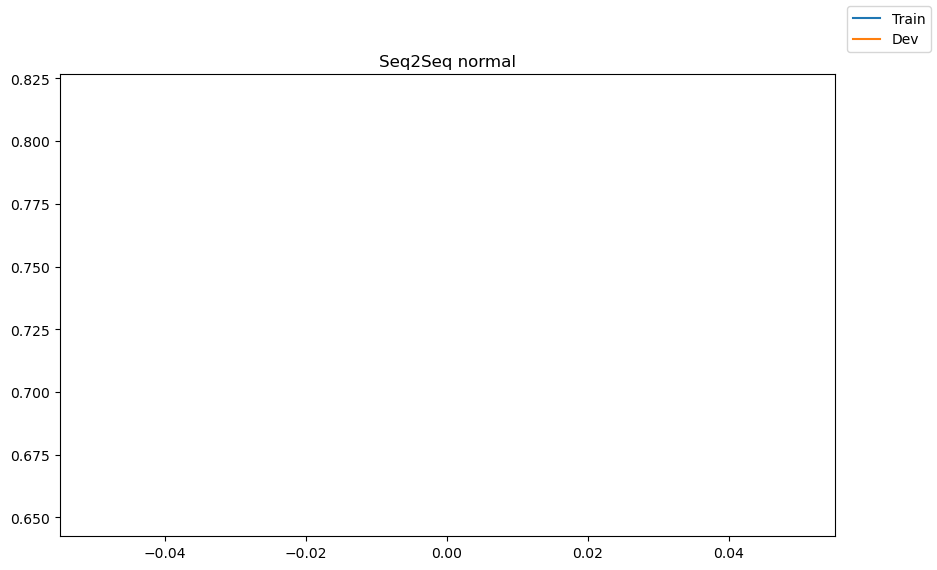

Epoch:  0 avg loss: 0.8182965518006986 dev loss: 0.6508481893488156 Time taken: 310.07444024086
Epoch:  1 avg loss: 0.6070984121959698 dev loss: 0.6508481893488156 Time taken: 265.55709862709045
Epoch:  2 avg loss: 0.531528431109735 dev loss: 0.6508481893488156 Time taken: 334.3194365501404


KeyboardInterrupt: 

In [52]:
total_batches = len(Train_loader);
for epoch in range(num_epochs):
    epoch_start = time.time();
    running_sum = 0;
    done = 0;
    cur_epoch_loss = run_model(Train_loader, model, training = True, verbose=1);
    if(epoch % 3 == 0):
        cur_dev_loss = run_model(Dev_loader, model, training = False, verbose=1); #not training on the dev set.
    train_loss.append(cur_epoch_loss);
    dev_loss.append(cur_dev_loss);
    if(epoch % 5 == 0):
        plot_losses(train_loss, dev_loss); #plotting our losses at each epoch.
    print("Epoch: ", epoch, "avg loss:", cur_epoch_loss, "dev loss:", cur_dev_loss, "Time taken:", time.time() - epoch_start);
    store_checkpoint(model, optimizer, epoch, cur_epoch_loss, 's9' + str(epoch) + '.pth', encoder_vectors, decoder_vectors);
    #now we will run it on the dev set to get loss curves.
    with open('9_tf_math_loss_curves.pkl', 'wb') as f:
        pickle.dump([train_loss, dev_loss], f);

In [58]:
def beam_search_output(problems, problem_lengths): #now we do beam search on this.
    #how to?
    #we need to keep track of the top k outputs at each step.
    k = 1;
    outs, (h, c), _ = model(problems, problem_lengths, None);
    return outs;
def get_sentence(indices):
    actual = indices;
    for i in range(len(indices)):
        if(indices[i] == decoder_vectors.word_to_index['<END>'] or indices[i] == decoder_vectors.word_to_index['<PAD>']):
            actual = indices[:i];
            break;
    return ''.join([decoder_vectors.index_to_word[i.item()] for i in actual]);

In [60]:
len(Train_loader)

619

In [79]:
exacts = 0;
total = 0;
# dataloader = DataLoader(mathDataset(val_data, global_max_len), batch_size=1, shuffle=True, collate_fn=collate_fn);

for i, (problems, problem_lengths, linear_formulas) in enumerate(Train_loader):
    problems = problems.to(device);
    linear_formulas = linear_formulas.to(device);
    # problems_lengths = torch.tensor(problems_lengths).to(device);
    outs = beam_search_output(problems, problem_lengths);
    decoder_vectors.word_to_index['<END>']
    preds = outs.argmax(dim=-1);
    predicted_sentence = [get_sentence(preds[i]) for i in range(preds.shape[0])];
    actual_sentence = [get_sentence(linear_formulas[i]) for i in range(linear_formulas.shape[0])];
    match = [predicted_sentence[i] == actual_sentence[i] for i in range(len(predicted_sentence))];
    exacts += sum(match);
    total += len(match);
    print("Exact match:", exacts, "out of", total, "%:", exacts/total, end = "           \r");
    # for i in range(len(indices)):
    #     test_data[indices[i]]['predicted'] = predicted_sentence[i];

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.76 GiB is allocated by PyTorch, and 692.66 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [53]:
#now we will save the lists that we have prepared.
store_checkpoint(model, optimizer, epoch, cur_epoch_loss, 'lstm_lstm_attn.pth', encoder_vectors, decoder_vectors);